# Calculus Experiments
Run this file to reproduce our results on the calculus data set.

In [1]:
import pandas as pd
import Experiment_calculus as exca

# Adjust pandas options to see all columns and to read subgroup descriptions fully
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', 200)

In [13]:
dat = pd.read_csv("Data/Calc_filtered.csv")
dat.head(1)

,course_code,collegeyear,FinalExam,WeeklyTests,StartTest,Midterm,CalculatedNumericResult,EndResult,Passed,origin,sex,croho,type_vooropleiding,double_major,course_repeater,active_minutes,total_course_activities,nightly_activities,distinct_days,logged_in_weekly,nr_files_viewed,nr_distinct_files_viewed,nr_slides_viewed,nr_practice_exams_viewed
0,2WBB0,2025,NaN,7.0,4.5,4.5,0.5,NVD,False,ORIGIN_E,SEX_M,B Applied Physics,BUITENL_SL,False,False,23.0,96.0,6.0,9.0,0.0,20.0,9.0,0.0,13.0


In [17]:
len(dat)*0.2

389.20000000000005

### Run the exceptional model mining framework
It creates files: 
* subgroup_linear_calculus.csv
* subgroup_results_calculus.csv
* coefs_calculus.csv

In [3]:
exca.main(test_size=0.3, min_size=70) 

Collected 50 subgroup models.
Exported 50 subgroup models to Results/subgroup_linear_calculus.csv
Complex baseline evaluation metrics: {'r2': 0.1105, 'mae': np.float64(1.5936), 'mse': np.float64(3.6728), 'mean_residual': -0.073, 'y_pred': 658     6.232278
137     5.474125
258     5.576005
374     6.077735
1610    7.179685
          ...   
248     6.109142
1739    7.223106
1090    6.574026
1617    6.255494
1448    7.139777
Length: 582, dtype: float64}


### Analyze the resulting subgroups

In [11]:
df_s = pd.read_csv("results/subgroup_results_calculus.csv")
df_s[['r2']].iloc[-1]

r2    0.1105
Name: 50, dtype: float64

In [5]:
# Assign rank: one per row (since you now have only subgroup_model rows)
df_s['subgroup_rank'] = (df_s.index + 1).astype("object")
df_s.loc[df_s['model_type'] == 'global', 'subgroup_rank'] = "N/A"

# Round columns for better readability
for col, ndigits in [('cookD', 2), ('r2', 3), ('mae', 3), ('mse', 3), ('mean_residual', 3),
                     ('global_baseline_r2', 3), ('global_baseline_mae', 3), ('global_baseline_mse', 3), ('global_baseline_mean_residual', 3),
                     ('mean_baseline_r2', 3), ('mean_baseline_mae', 3), ('mean_baseline_mse', 3), ('mean_baseline_mean_residual', 3)]:
    if col in df_s.columns:
        df_s[col] = df_s[col].round(ndigits)

# Compare r2 between subgroup_model and global baseline for each row
df_s['subgroup_r2_better'] = (df_s['r2'] > df_s['global_baseline_r2']).astype("object")
df_s.loc[df_s['model_type'] == 'global', 'subgroup_r2_better'] = None
df_s['subgroup_better_global'] = (df_s['ttest_p'] < 0.1)
df_s.loc[df_s['model_type'] == 'global', 'subgroup_better_global'] = None
df_s['subgroup_better_mean'] = (df_s['ttest_p_mean'] < 0.1)
df_s.loc[df_s['model_type'] == 'global', 'subgroup_better_mean'] = None
df_s['global_better_mean'] = (df_s['ttest_p_mean_global'] < 0.1)
df_s.loc[df_s['model_type'] == 'global', 'global_better_mean'] = None

# Add decision column based on the rules
def determine_decision(row):
    sg = row['subgroup_better_global']
    sm = row['subgroup_better_mean']
    gm = row['global_better_mean']
    
    if sg and sm:
        return "True discovery"
    elif sg and not sm:
        return "True discovery, but model not appropriate"
    elif not sg and sm:
        return "Weak discovery"
    elif not sg and not sm and gm:
        return "False discovery"
    else:
        return "Model not appropriate"

df_s['decision'] = df_s.apply(determine_decision, axis=1)

# Specify desired column order
main_cols = [
    'subgroup_rank', 'model_type', 'description', 'decision', 'subgroup_r2_better', 'cookD', 'n_train', 'n_test',
    'r2', 'global_baseline_r2', 'mean_baseline_r2', 
    'mae', 'global_baseline_mae', 'mean_baseline_mae',
    'mse', 'global_baseline_mse', 'mean_baseline_mse',
    'mean_residual', 'global_baseline_mean_residual', 'mean_baseline_mean_residual'
]
rest_cols = [c for c in df_s.columns if c not in main_cols]
new_order = main_cols + rest_cols

# Reorder columns
df_s = df_s[new_order]

/var/folders/0_/xw_ks0g978df8kf5jp1rvf2h0000gn/T/ipykernel_38954/2205722591.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_s.loc[df_s['model_type'] == 'global', 'subgroup_better_global'] = None
/var/folders/0_/xw_ks0g978df8kf5jp1rvf2h0000gn/T/ipykernel_38954/2205722591.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_s.loc[df_s['model_type'] == 'global', 'subgroup_better_mean'] = None
/var/folders/0_/xw_ks0g978df8kf5jp1rvf2h0000gn/T/ipykernel_38954/2205722591.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with

In [6]:
# Extract all true discoveries
df_s[df_s['decision'].isin(['True discovery',])][['subgroup_rank', 'description', 'decision', 'n_test', 'cookD','r2', 'global_baseline_r2', 'mean_baseline_r2']]

,subgroup_rank,description,decision,n_test,cookD,r2,global_baseline_r2,mean_baseline_r2
2,3,croho=='B Computer Science & Engineering' ∧ origin=='ORIGIN_E' ∧ sex=='SEX_M',True discovery,32,164.21,0.226,-0.270,-0.039
36,37,origin=='ORIGIN_N' ∧ sex=='SEX_V' ∧ type_vooropleiding=='VWO',True discovery,34,51.99,-0.167,-1.418,-0.566
39,40,sex=='SEX_V' ∧ type_vooropleiding=='VWO',True discovery,35,50.10,-0.130,-1.257,-0.494
40,41,double_major==False ∧ sex=='SEX_V' ∧ type_vooropleiding=='VWO',True discovery,35,50.10,-0.130,-1.257,-0.494
43,44,course_repeater==np.False_ ∧ croho=='B Industrial Engineering' ∧ type_vooropleiding=='VWO',True discovery,31,45.14,0.214,-0.038,-0.056
44,45,course_repeater==np.False_ ∧ origin=='ORIGIN_N' ∧ sex=='SEX_V',True discovery,29,42.98,0.150,-0.408,-0.120
45,46,course_repeater==np.False_ ∧ croho=='B Industrial Engineering' ∧ origin=='ORIGIN_N',True discovery,32,42.89,0.204,0.022,-0.025
46,47,origin=='ORIGIN_N' ∧ sex=='SEX_V',True discovery,41,41.02,0.123,-0.629,-0.242
47,48,double_major==False ∧ origin=='ORIGIN_N' ∧ sex=='SEX_V',True discovery,41,41.02,0.123,-0.629,-0.242
48,49,croho=='B Industrial Engineering' ∧ sex=='SEX_M' ∧ type_vooropleiding=='VWO',True discovery,30,40.56,0.234,-0.025,-0.086


In [7]:
# Explore other possible interesting subgroups
df_s[(df_s['decision'].isin(['Model not appropriate', 'Weak discovery'])) & ( df_s['r2'] > 0) & ( df_s['r2'] > df_s['global_baseline_r2'])][['subgroup_rank', 'description', 'decision', 'n_test', 'cookD','r2', 'global_baseline_r2', 'mean_baseline_r2']]

,subgroup_rank,description,decision,n_test,cookD,r2,global_baseline_r2,mean_baseline_r2
8,9,croho=='B Computer Science & Engineering' ∧ origin=='ORIGIN_E' ∧ type_vooropleiding=='BUITENL_SL',Model not appropriate,42,107.38,0.023,-0.181,-0.003
12,13,croho=='B Computer Science & Engineering' ∧ origin=='ORIGIN_E',Model not appropriate,43,99.98,0.042,-0.180,-0.001
13,14,croho=='B Computer Science & Engineering' ∧ double_major==False ∧ origin=='ORIGIN_E',Model not appropriate,43,99.98,0.042,-0.180,-0.001
23,24,croho=='B Electrical Engineering' ∧ origin=='ORIGIN_N' ∧ sex=='SEX_M',Model not appropriate,43,67.19,0.068,0.001,-0.002
32,33,course_repeater==np.False_ ∧ croho=='B Data Science (joint degree)' ∧ double_major==False,Model not appropriate,39,53.52,0.139,0.067,-0.003
33,34,course_repeater==np.False_ ∧ croho=='B Data Science (joint degree)',Model not appropriate,39,52.78,0.140,0.067,-0.003
34,35,croho=='B Computer Science & Engineering' ∧ sex=='SEX_M',Model not appropriate,78,52.63,0.107,0.056,-0.002
35,36,croho=='B Computer Science & Engineering' ∧ double_major==False ∧ sex=='SEX_M',Weak discovery,77,52.63,0.125,0.049,-0.000


In [8]:
# Count all decisions
df_s['decision'].value_counts()

decision
Model not appropriate                        35
True discovery                               11
False discovery                               2
True discovery, but model not appropriate     2
Weak discovery                                1
Name: count, dtype: int64

In [9]:
# Selected interesting subgroups
df_calc_coefs = pd.read_csv('results/coefs_calculus.csv')

# Create display labels: #1, #2, ...
chosen = [3, 44, 46, 49, 34, 35]#[3, 44, 45, 46, 47, 49, 34, 35] -> removed ones with no significant coefs.

df_lins = df_calc_coefs[df_calc_coefs['subgroup'].isin(['#'+str(i) for i in chosen] + ['Ω'])]

df_lins = df_lins[df_lins['term'] != 'const']

df_s[df_s['subgroup_rank'].isin(chosen)][['subgroup_rank', 'description', 'decision', 'n_test', 'cookD','r2', 'global_baseline_r2']]

,subgroup_rank,description,decision,n_test,cookD,r2,global_baseline_r2
2,3,croho=='B Computer Science & Engineering' ∧ origin=='ORIGIN_E' ∧ sex=='SEX_M',True discovery,32,164.21,0.226,-0.270
33,34,course_repeater==np.False_ ∧ croho=='B Data Science (joint degree)',Model not appropriate,39,52.78,0.140,0.067
34,35,croho=='B Computer Science & Engineering' ∧ sex=='SEX_M',Model not appropriate,78,52.63,0.107,0.056
43,44,course_repeater==np.False_ ∧ croho=='B Industrial Engineering' ∧ type_vooropleiding=='VWO',True discovery,31,45.14,0.214,-0.038
45,46,course_repeater==np.False_ ∧ croho=='B Industrial Engineering' ∧ origin=='ORIGIN_N',True discovery,32,42.89,0.204,0.022
48,49,croho=='B Industrial Engineering' ∧ sex=='SEX_M' ∧ type_vooropleiding=='VWO',True discovery,30,40.56,0.234,-0.025


In [38]:
terms = []

for i in range(len(df_lins)):
    t = df_lins.iloc[i]['term']
    
    if t == 'total_attended_labsessions':
        terms.append('labsessions')
    elif t == 'active_minutes':
        terms.append('active (mins)')
    elif t == 'nr_distinct_files_viewed':
        terms.append('distinct files')
    elif t == 'total_course_activities':
        terms.append('course activities')
    elif t == 'distinct_days':
        terms.append('active days')
    elif t == 'nr_files_viewed':
        terms.append('total files')
    elif t == 'nr_practice_exams_viewed':
        terms.append('practice exams')
    elif t == 'nightly_activities':
        terms.append('active at night')
    elif t == 'logged_in_weekly':
        terms.append("weekly logins")
    elif t == 'nr_slides_viewed':
        terms.append('slides')
    else:
        print(t)

df_lins['Effort'] = terms

49 56


/var/folders/0_/xw_ks0g978df8kf5jp1rvf2h0000gn/T/ipykernel_38954/142309655.py:19: UserWarning: The palette list has more values (16) than needed (7), which may not be intended.
  ax = sns.barplot(


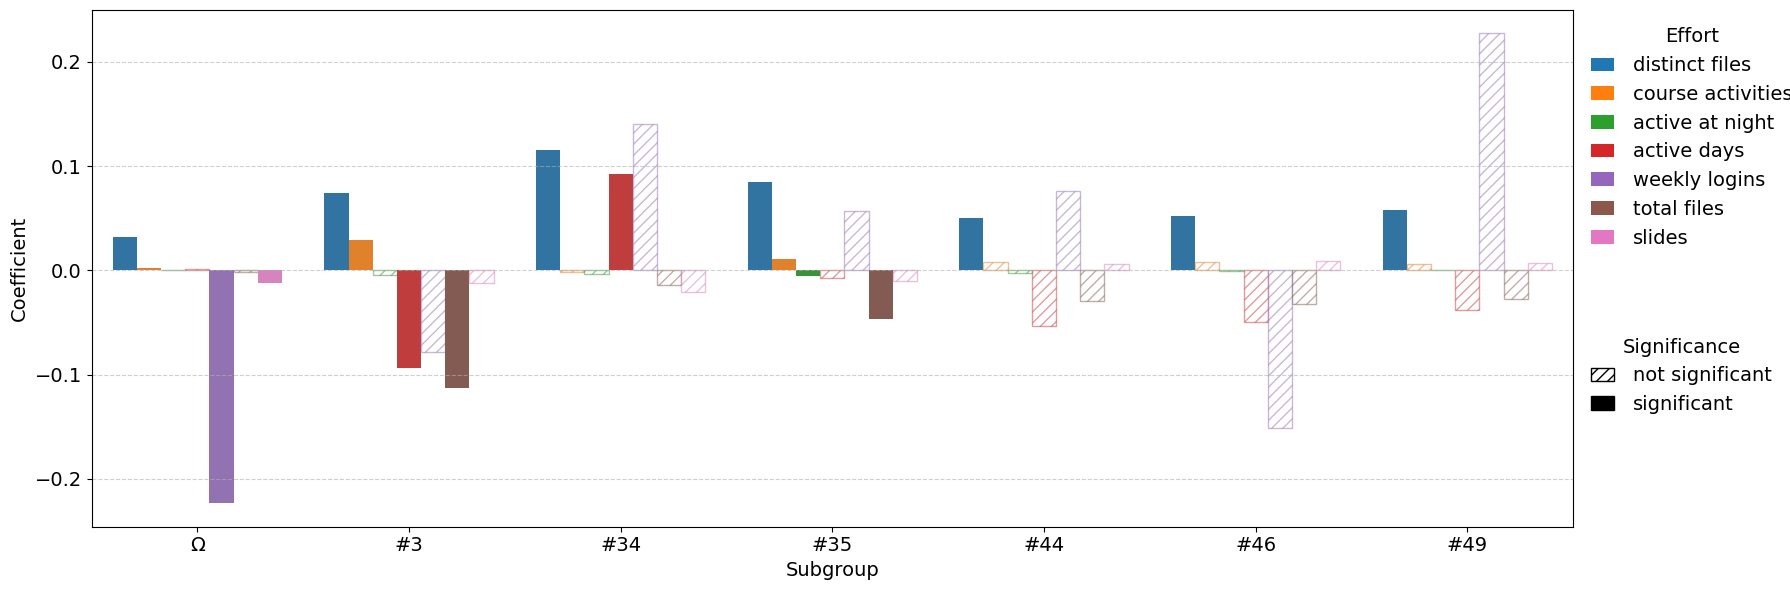

In [39]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from matplotlib.patches import Patch


#####
# To DO: Change bar fill depending on significant, yes or no 
#####

palette = sns.color_palette("tab10", 16)
#palette = random.shuffle(palette)
plt.figure(figsize=(18, 6))

df = df_lins#[ df_all['term'] != 'Intercept']

ax = sns.barplot(
    data=df,
    x="subgroup",
    y="coef",
    hue="Effort",
    dodge=True,
    palette=palette
)
patches_sorted = sorted(ax.patches[:-7], key=lambda p: p.get_x())
print(len(df_lins['significant']), len(ax.patches))
for patch, sig in zip(patches_sorted, df_lins['significant']):
    if sig == 'no':
        patch.set_hatch("///")      # striped fill
        patch.set_edgecolor(patch.get_facecolor())  # keep original color for stripes
        patch.set_facecolor("white")  # base color for hatch
        patch.set_alpha(0.5)
#     # sig == 1 → leave as solid color

ax.set_xlabel("Subgroup", fontsize=14)
ax.set_ylabel("Coefficient", fontsize=14)

# Grid (clean style)how 
ax.yaxis.grid(True, linestyle="--", alpha=0.6)
ax.xaxis.grid(False)
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)

# # Legend outside
# # Smaller legend outside the plot
# Custom legend
# Color legend for terms
terms = df_lins["Effort"].unique()
palette = sns.color_palette("tab10", len(terms))
color_handles = [Patch(facecolor=palette[i], label=term) for i, term in enumerate(terms)]

# # # Hatch legend for significance
sig_handles = [
    Patch(facecolor="white", edgecolor="black", hatch="///", label="not significant"),
    Patch(facecolor="black", edgecolor="black", label="significant")
]

# Combine legends 
first_legend = ax.legend(handles=color_handles, title="Effort", bbox_to_anchor=(1.0, 1), loc="upper left", fontsize=14, title_fontsize=14,    frameon=False,       # cleaner look
    handlelength=1.2,
    handletextpad=1) 
ax.add_artist(first_legend) 
ax.legend(handles=sig_handles, title="Significance", bbox_to_anchor=(1.0, 0.4), loc="upper left", fontsize=14, title_fontsize=14,    frameon=False,       # cleaner look
    handlelength=1.2,
    handletextpad=1)

plt.tight_layout()
plt.show()